## Collecting data from gnomAD

Variants data downloaded from [gnomAD](https://gnomad.broadinstitute.org/downloads#v4)

Use command line for initial processing

1. Filtered only PASS variants 

```zsh
bcftools view -f 'PASS,.' gnomad.exomes.v4.0.sites.chr22.vcf.bgz > filtered_gnomad22.bgz
```
For next parcing we can use also **command line** or **python**

2. Extract the necessary data

for this step we need **bcftools** utility

```zsh
bcftools query -f '%CHROM\t%POS\t%ID\t%REF\t%ALT\t%AC\t%AC_afr\t%AC_amr\t%AC_nfe
\t%AC_asj\t%AC_sas\t%AC_eas\t%AC_mid\t%AC_fin\t%AN\t%AN_afr\t%AN_amr\t%AN_nfe\t%AN_asj
\t%AN_sas\t%AN_eas\t%AN_mid\t%AN_fin\t%AF\t%AF_afr\t%AF_amr\t%AF_nfe\t%AF_asj\t%AF_sas
\t%AF_eas\t%AF_mid\t%AF_fin\t%vep=\n' filtered_gnomad22.bgz > processed_gnomad22.vcf.bgz
```


In [145]:
import csv

import cyvcf2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
vcf_path = 'data/gnomad.exomes.v4.0.sites.chr22.vcf.bgz'
vcf = cyvcf2.VCF(vcf_path)

# Define the columns to extract
info_fields_to_extract = ['AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
               'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
               'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin', 'vep']
vep_field_mapping = {
        1: 'Consequence', 3: 'SYMBOL',
        5: 'Feature_Type', 6: 'Feature', 7: 'BIOTYPE', 8: 'EXON', 9: 'INTRON',
        17: 'ALLELE_NUM', 24: 'CANONICAL',
        42: 'LoF', 43: 'LoF_filter', 44: 'LoF_flags', 45: 'LoF_info'}

column_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 
                'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
                'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
                'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin',
                'Consequence', 'SYMBOL', 'Feature_Type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM',
                'CANONICAL', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info']

# Initialize an empty list to store the extracted data
data = []

# Iterate over each variant in the VCF file
counter = 1
for variant in vcf:
    variant_data = [variant.CHROM, variant.POS, variant.ID, variant.REF, variant.ALT[0]]
    info_data = [variant.INFO.get(field, '.') for field in info_fields_to_extract]
    vep_annotation = variant.INFO.get('vep')

    # Handle multiple transcripts in vep if present
    if vep_annotation:
        vep_transcripts = vep_annotation.split(',')
        for transcript in vep_transcripts:
            split_transcript = transcript.split('|')
            vep_fields = []
            for key in vep_field_mapping.keys():
                try:
                    vep_fields.append(split_transcript[key])
                except:
                    vep_fields.append('.')
            data.append(variant_data + info_data[:-1] + vep_fields)
    else:
        data.append(variant_data + info_data + ['.'])
    counter += 1
output_file_name = f"output_{vcf_path.split('.')[-3]}.tsv"
with open(output_file_name, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    # Write the header
    writer.writerow(column_names)
    # Write the data rows
    writer.writerows(data)
# Create a pandas DataFrame from the extracted data

KeyboardInterrupt: 

Проверка на тестовых данных 17.03.2024

Порядок работы:

1. **Фильтруем по статусу PASS**

```zsh
bcftools view -f 'PASS,.' gnomad.exomes.v4.0.sites.chr22.vcf.bgz > filtered_gnomad22.bgz
```
Уже получается распакованный архив

2. **Дальше запускаем наш парсер и записываем либо файл, либо сразу датафрейм.**

3. Пытаемся понять **суммарный AC по каждому белок-кодирующему транскрипту c потерей функции** на игрушечном наборе данных из хромосомы 22 (25 тысяч строк в начале файла + 25 тысяч строк с конца файла)

>Значение AC (Количество аллелей) в GnomeAD — это мера того, сколько людей в базе данных имеют аллель (вариантную форму) для определенного гена в указанной позиции. Значение AC находится в диапазоне от 0 до n, где n — общее количество людей в базе данных, чьи геномные данные доступны. Более высокие значения AC могут указывать на то, что вариант распространен, а более низкие значения предполагают, что вариант редок или отсутствует.

```zsh
protein_transcript_df = vcf_df[
    (vcf_df['Feature_Type'] == 'Transcript') & 
    (vcf_df['BIOTYPE'] == 'protein_coding') &
    (vcf_df['Consequence'] == 'stop_gained')
    ]
```
Получилось 1220 записей

Посмотрим, сколько уникальных транскриптов:

```zsh
protein_transcript_df['Feature'].nunique()
```

Получилось 104 трансрипта

Смотрим сумму AC по уникальным транскриптам:

```zsh
sum_ac_per_transcript = protein_transcript_df.groupby('Feature')['AC'].sum()
```
Нашли транскрипт с самой высокой суммой:

```zsh
transcript_with_max_ac = sum_ac_per_transcript.idxmax()
max_ac_sum = sum_ac_per_transcript.max()

print("Transcript with the largest sum of AC values:", transcript_with_max_ac)
print("Largest sum of AC values:", max_ac_sum)

#Transcript with the largest sum of AC values: ENST00000643316
#Largest sum of AC values: 731224
```
Этот транскрипт гена **GAB4**

Какие мутации с потерей функции в этом гене очень распространены в популяциях:

* AC = 177956, G -> A, intron 4/10
* AC = 553208, C -> A, intron 3/10
* AC = 30, G -> A, intron 4/10

В этих случаях возникает укороченный вариант белка, но, похоже, это не очень влияет на его функциональную значимость

19.03.2024

Сделали датафрейм: номер транскрипта, номер гена, суммарное AC, суммарные варианты

In [388]:
vcf_path = '/home/irina/BI_projects/genetic_variance/data/processed_data/test_chr22_50k.vcf'
vcf = cyvcf2.VCF(vcf_path)

# Define the columns to extract
info_fields_to_extract = ['AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
               'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
               'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin', 'vep']
vep_field_mapping = {
        1: 'Consequence', 2: 'IMPACT', 3: 'SYMBOL', 4: 'Gene',
        5: 'Feature_Type', 6: 'Feature', 7: 'BIOTYPE', 8: 'EXON', 9: 'INTRON',
        17: 'ALLELE_NUM', 21: 'VARIANT_CLASS', 24: 'CANONICAL',
        44: 'LoF', 45: 'LoF_filter', 46: 'LoF_flags', 47: 'LoF_info'}

column_names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 
                'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin',
                'AN', 'AN_afr', 'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
                'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas', 'AF_mid', 'AF_fin',
                'Consequence', 'IMPACT', 'SYMBOL', 'Gene', 'Feature_Type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM',
                'VARIANT_CLASS', 'CANONICAL', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info']

# Initialize an empty list to store the extracted data
data = []

# Iterate over each variant in the VCF file
counter = 1
for variant in vcf:
    variant_data = [variant.CHROM, variant.POS, variant.ID, variant.REF, variant.ALT[0]]
    info_data = [variant.INFO.get(field, '.') for field in info_fields_to_extract]
    vep_annotation = variant.INFO.get('vep')

    # Handle multiple transcripts in vep if present
    if vep_annotation:
        vep_transcripts = vep_annotation.split(',')
        for transcript in vep_transcripts:
            split_transcript = transcript.split('|')
            vep_fields = []
            for key in vep_field_mapping.keys():
                try:
                    vep_fields.append(split_transcript[key])
                except:
                    vep_fields.append('.')
            data.append(variant_data + info_data[:-1] + vep_fields)
    else:
        data.append(variant_data + info_data + ['.'])
    counter += 1
vcf_df = pd.DataFrame(data, columns=column_names)

In [389]:
vcf_df

,CHROM,POS,ID,REF,ALT,AC,AC_afr,AC_amr,AC_nfe,AC_asj,...,BIOTYPE,EXON,INTRON,ALLELE_NUM,VARIANT_CLASS,CANONICAL,LoF,LoF_filter,LoF_flags,LoF_info
0,chr22,10736362,rs879131185,C,T,63,0,1,50,0,...,snRNA,,,1,SNV,YES,,,,
1,chr22,10736399,rs1206833908,T,C,442,13,5,298,5,...,snRNA,,,1,SNV,YES,,,,
2,chr22,10736400,rs1289580688,G,A,15,0,0,9,0,...,snRNA,,,1,SNV,YES,,,,
3,chr22,10736414,None,G,C,1,0,0,1,0,...,snRNA,,,1,SNV,YES,,,,
4,chr22,10736415,None,C,T,1,0,0,1,0,...,snRNA,,,1,SNV,YES,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602483,chr22,50801268,rs370064763,T,C,1,0,0,1,0,...,,,,1,SNV,,,,,
602484,chr22,50801268,rs370064763,T,C,1,0,0,1,0,...,,,,1,SNV,,,,,
602485,chr22,50801268,rs370064763,T,C,1,0,0,1,0,...,,,,1,SNV,,,,,
602486,chr22,50801268,rs370064763,T,C,1,0,0,1,0,...,,,,1,SNV,,,,,


In [406]:
list(vcf_df['Consequence'].unique())

['upstream_gene_variant',
 'downstream_gene_variant',
 'non_coding_transcript_exon_variant',
 'splice_polypyrimidine_tract_variant&intron_variant&non_coding_transcript_variant',
 'intron_variant&non_coding_transcript_variant',
 'splice_donor_region_variant&intron_variant&non_coding_transcript_variant',
 'splice_region_variant&non_coding_transcript_exon_variant',
 'splice_region_variant&splice_polypyrimidine_tract_variant&intron_variant&non_coding_transcript_variant',
 'splice_donor_5th_base_variant&intron_variant&non_coding_transcript_variant',
 'splice_donor_variant&non_coding_transcript_variant',
 'splice_region_variant&intron_variant&non_coding_transcript_variant',
 'splice_acceptor_variant&splice_polypyrimidine_tract_variant&intron_variant&non_coding_transcript_variant',
 'splice_polypyrimidine_tract_variant&splice_region_variant&intron_variant&non_coding_transcript_variant',
 'regulatory_region_variant',
 'TF_binding_site_variant',
 'splice_donor_variant&splice_donor_5th_base_vari

### График по распределению интересных Consequence в белковых транскриптах

In [411]:
conseq_in_prot = vcf_df[
    (vcf_df['Feature_Type'] == 'Transcript') & 
    (vcf_df['BIOTYPE'] == 'protein_coding') ]

In [443]:
values_to_filter = ['stop_gained', 'frameshift_variant', 'splice_donor_variant', 'splice_acceptor_variant']

# Filter the DataFrame based on the specified values in the 'column_name' column
filtered_conseq_in_prot = conseq_in_prot[conseq_in_prot['Consequence'].isin(values_to_filter)]

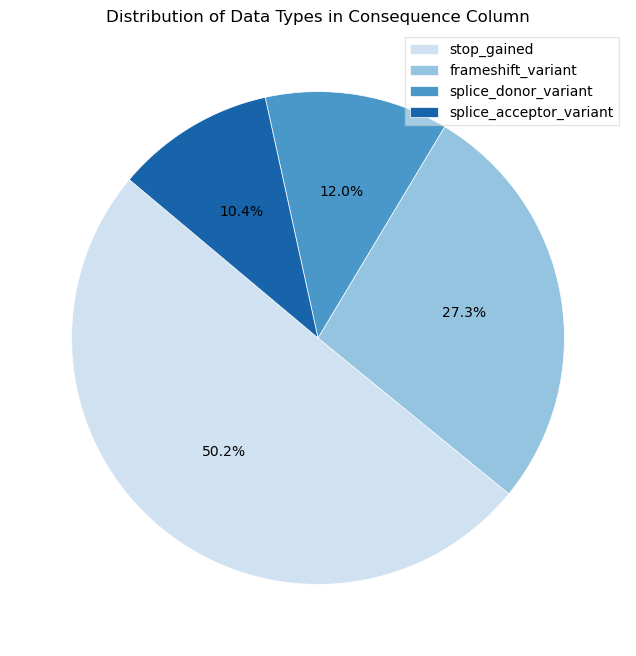

In [445]:
sizes = filtered_conseq_in_prot['Consequence'].value_counts()

# Set a seaborn palette with a specified number of colors
num_colors = len(sizes)
colors = sns.color_palette('Blues', num_colors)

# Create the pie plot
plt.figure(figsize=(8, 8))
patches, texts, _ = plt.pie(sizes, 
                            colors=colors, startangle=140, 
                            autopct='%1.1f%%',
                            wedgeprops=dict(edgecolor='white', linewidth=0.5))
plt.legend(patches, values_to_filter, loc="upper right", bbox_to_anchor=(1, 1), fontsize=10, fancybox=False, shadow=False, framealpha=0.5)
plt.title('Distribution of Data Types in Consequence Column')
plt.show()
plt.show()

In [83]:
protein_transcript_df = vcf_df[
    (vcf_df['Feature_Type'] == 'Transcript') & 
    (vcf_df['BIOTYPE'] == 'protein_coding') &
    (vcf_df['Consequence'] == 'stop_gained')
    ]

In [84]:
protein_transcript_df.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'AC', 'AC_afr', 'AC_amr', 'AC_nfe',
       'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin', 'AN', 'AN_afr',
       'AN_amr', 'AN_nfe', 'AN_asj', 'AN_sas', 'AN_eas', 'AN_mid', 'AN_fin',
       'AF', 'AF_afr', 'AF_amr', 'AF_nfe', 'AF_asj', 'AF_sas', 'AF_eas',
       'AF_mid', 'AF_fin', 'Consequence', 'SYMBOL', 'Gene', 'Feature_Type',
       'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'ALLELE_NUM', 'VARIANT_CLASS',
       'CANONICAL', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info'],
      dtype='object')

In [85]:
protein_transcript_df['Feature'].unique()

array(['ENST00000643195', 'NM_001005239.2', 'ENST00000343518',
       'NM_001136213.1', 'ENST00000359963', 'NM_014406.5',
       'ENST00000331428', 'ENST00000684488', 'NM_001318251.3',
       'NM_001386955.1', 'NM_001386956.1', 'NM_001386957.1',
       'NM_175878.5', 'ENST00000400588', 'ENST00000643316',
       'NM_001037814.1', 'NM_001366857.1', 'XM_011546114.2',
       'XM_011546115.1', 'XM_011546117.1', 'XM_017028575.1',
       'XM_017028576.1', 'XM_011546116.2', 'ENST00000312108',
       'ENST00000360719', 'ENST00000395650', 'ENST00000405237',
       'ENST00000457250', 'NM_001145134.2', 'NM_001145135.2',
       'NM_001145137.2', 'NM_004377.4', 'NM_152245.3', 'NM_152246.3',
       'ENST00000417176', 'ENST00000406938', 'NM_005198.5',
       'ENST00000329492', 'NM_012324.6', 'XM_011530679.2',
       'XM_011530680.2', 'XM_011530681.2', 'ENST00000216124',
       'ENST00000356098', 'ENST00000395619', 'ENST00000395621',
       'ENST00000453344', 'NM_000487.6', 'NM_001085425.3',
       'NM

In [95]:
filtered_protein_transcript_df = protein_transcript_df[
    protein_transcript_df['Feature'].str.contains('ENST|NM')]

In [275]:
filtered_protein_transcript_df

,CHROM,POS,ID,REF,ALT,AC,AC_afr,AC_amr,AC_nfe,AC_asj,...,BIOTYPE,EXON,INTRON,ALLELE_NUM,VARIANT_CLASS,CANONICAL,LoF,LoF_filter,LoF_flags,LoF_info
3769,chr22,15528289,None,C,A,1,0,0,0,0,...,protein_coding,1/1,,1,SNV,YES,,,HC,
3777,chr22,15528289,None,C,A,1,0,0,0,0,...,protein_coding,1/1,,1,SNV,YES,,,HC,
3945,chr22,15528892,None,C,A,1,0,0,0,0,...,protein_coding,1/1,,1,SNV,YES,,,HC,
3953,chr22,15528892,None,C,A,1,0,0,0,0,...,protein_coding,1/1,,1,SNV,YES,,,HC,
8001,chr22,15690179,rs200375190,G,A,21622,70,123,19804,7,...,protein_coding,1/11,,1,SNV,YES,,,HC,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564818,chr22,50776725,rs375595282,G,T,2,0,0,2,0,...,protein_coding,5/10,,1,SNV,,,,HC,
564824,chr22,50776725,rs375595282,G,T,2,0,0,2,0,...,protein_coding,5/10,,1,SNV,,,,HC,
564830,chr22,50776725,rs375595282,G,T,2,0,0,2,0,...,protein_coding,5/10,,1,SNV,,,,HC,
564836,chr22,50776725,rs375595282,G,T,2,0,0,2,0,...,protein_coding,4/9,,1,SNV,,,,HC,


In [101]:
sum_ac_per_transcript = filtered_protein_transcript_df.groupby('Feature')['AC'].sum()

In [102]:
sum_ac_per_transcript

Feature
ENST00000216124      78
ENST00000216139      74
ENST00000262795      39
ENST00000312108      80
ENST00000329492      14
                   ... 
NM_012324.6          14
NM_014406.5        8826
NM_152245.3          80
NM_152246.3          80
NM_175878.5         146
Name: AC, Length: 84, dtype: int64

In [103]:
transcript_with_max_ac = sum_ac_per_transcript.idxmax()
max_ac_sum = sum_ac_per_transcript.max()

print("Transcript with the largest sum of AC values:", transcript_with_max_ac)
print("Largest sum of AC values:", max_ac_sum)

Transcript with the largest sum of AC values: ENST00000643316
Largest sum of AC values: 731224


In [273]:
filtered_protein_transcript_df[filtered_protein_transcript_df['Feature'] == 'ENST00000643316']

,CHROM,POS,ID,REF,ALT,AC,AC_afr,AC_amr,AC_nfe,AC_asj,...,BIOTYPE,EXON,INTRON,ALLELE_NUM,VARIANT_CLASS,CANONICAL,LoF,LoF_filter,LoF_flags,LoF_info
75381,chr22,16962810,None,G,A,1,0,0,1,0,...,protein_coding,10/10,,1,SNV,,,,HC,
80605,chr22,16963786,rs201165731,G,C,1,0,0,0,0,...,protein_coding,9/10,,1,SNV,,,,HC,
93703,chr22,16966169,None,G,A,1,0,1,0,0,...,protein_coding,6/10,,1,SNV,,,,HC,
106643,chr22,16969625,rs2041607,G,A,177956,2803,9450,102725,6018,...,protein_coding,4/10,,1,SNV,,,,HC,
107531,chr22,16969730,rs766763376,G,A,30,0,1,29,0,...,protein_coding,4/10,,1,SNV,,,,HC,
116967,chr22,16987979,rs1045885030,G,A,1,1,0,0,0,...,protein_coding,3/10,,1,SNV,,,,HC,
117147,chr22,16987991,rs763795980,G,A,8,0,0,6,0,...,protein_coding,3/10,,1,SNV,,,,HC,
117364,chr22,16987996,rs61743894,G,T,3,0,0,1,0,...,protein_coding,3/10,,1,SNV,,,,HC,
118461,chr22,16988078,rs1196516899,G,A,5,0,5,0,0,...,protein_coding,3/10,,1,SNV,,,,HC,
118539,chr22,16988084,rs1032243450,G,A,4,0,1,2,0,...,protein_coding,3/10,,1,SNV,,,,HC,


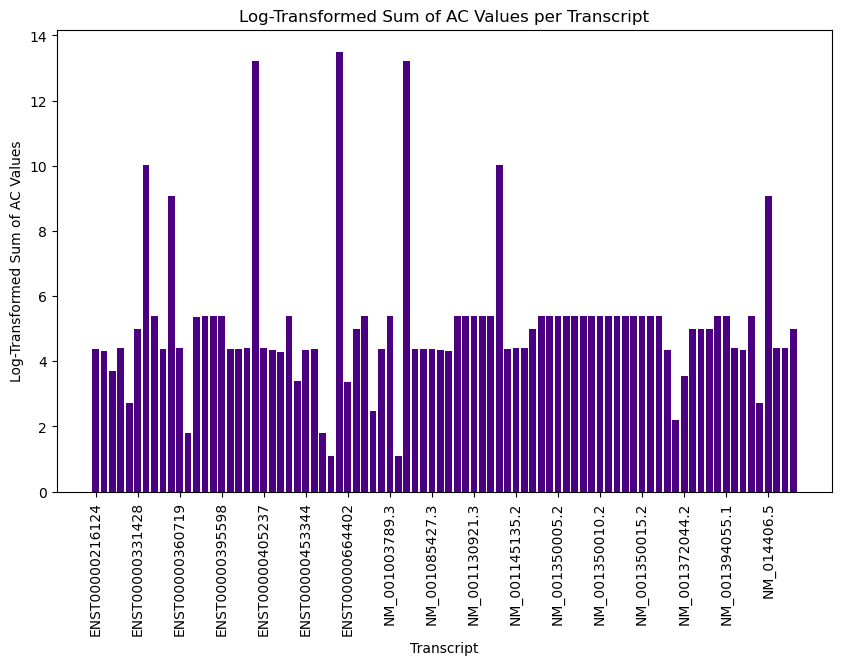

In [105]:
normalized_data = np.log1p(sum_ac_per_transcript)

# Create a histogram of the log-transformed data
plt.figure(figsize=(10, 6))
plt.bar(range(len(normalized_data)), normalized_data, color='indigo')
plt.xlabel('Transcript')
plt.ylabel('Log-Transformed Sum of AC Values')
plt.title('Log-Transformed Sum of AC Values per Transcript')
plt.xticks(range(0, len(normalized_data), 5), list(normalized_data.index[::5]), rotation=90)
plt.show()

In [308]:
filtered_protein_transcript_df[filtered_protein_transcript_df['SYMBOL'] == 'CCT8L2']['Feature'].unique()

array(['ENST00000359963', 'NM_014406.5'], dtype=object)

In [248]:
sum_ac_per_transcript = filtered_protein_transcript_df.groupby('Feature')['AC']

sum_ac = []

for key, group in sum_ac_per_transcript:
    unique_values = group.sum()  # Extract the unique values
    sum_ac.append(unique_values)

In [249]:
filtered_protein_transcript_df.groupby('Feature')['AC'].sum()

Feature
ENST00000216124      78
ENST00000216139      74
ENST00000262795      39
ENST00000312108      80
ENST00000329492      14
                   ... 
NM_012324.6          14
NM_014406.5        8826
NM_152245.3          80
NM_152246.3          80
NM_175878.5         146
Name: AC, Length: 84, dtype: int64

In [289]:
population_ac = ['AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin']

sum_population_ac = [[], [], [], [], [], [], [], []]


for idx, el in enumerate(population_ac):
    sum_population = []
    sum_AC_per_transcript = filtered_protein_transcript_df.groupby('Feature')[el]
    for key, group in sum_AC_per_transcript:
        unique_values = group.sum()
        sum_population.append(unique_values)
        sum_population_ac[idx].append(sum(sum_population))
        sum_population = []

In [290]:
gene_name_per_transcript = filtered_protein_transcript_df.groupby('Feature')['SYMBOL']
gene_names = []

for key, group in gene_name_per_transcript:
    unique_values = group.unique()  # Extract the unique values
    gene_names.extend(unique_values)


In [291]:
gene_id_per_transcript = filtered_protein_transcript_df.groupby('Feature')['Gene']

gene_id = []

for key, group in gene_id_per_transcript:
    unique_values = group.unique()  # Extract the unique values
    gene_id.extend(unique_values)

In [292]:
alt_per_transcript = filtered_protein_transcript_df.groupby('Feature')['ALT']

alt_sum = []

for key, group in alt_per_transcript:
    unique_values = len(group.sum())
    alt_sum.append(unique_values)

In [446]:
new_dataframe = pd.DataFrame({
    'Transcript_ID': filtered_protein_transcript_df['Feature'].unique(),
    'AC': sum_ac,
    'AC_afr': sum_population_ac[0],
    'AC_amr': sum_population_ac[1],
    'AC_nfe': sum_population_ac[2],
    'AC_asj': sum_population_ac[3],
    'AC_sas': sum_population_ac[4],
    'AC_eas': sum_population_ac[5],
    'AC_mid': sum_population_ac[6],
    'AC_fin': sum_population_ac[7],
    'Gene_name': gene_names,
    'Gene_id': gene_id,
    'Variant': alt_sum
})
#new_dataframe['AC'] = np.log1p(new_dataframe['AC'])
# Display the new DataFrame
display(new_dataframe)

,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant
0,ENST00000643195,78,0,14,46,0,4,6,0,2,ARSA,ENSG00000100299,17
1,NM_001005239.2,74,0,6,57,0,8,1,1,1,ACR,ENSG00000100312,18
2,ENST00000343518,39,0,5,20,0,6,3,0,4,SHANK3,ENSG00000251322,26
3,NM_001136213.1,80,0,8,60,0,2,1,3,0,CPT1B,ENSG00000205560,6
4,ENST00000359963,14,0,0,9,0,0,3,0,2,MAPK8IP2,ENSG00000008735,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,NM_001350017.2,14,0,0,9,0,0,3,0,2,MAPK8IP2,23542,12
80,NM_001394054.1,8826,2673,281,3534,108,1518,6,100,13,CCT8L2,150160,30
81,NM_001394055.1,80,0,8,60,0,2,1,3,0,CPT1B,1375,6
82,NM_007081.4,80,0,8,60,0,2,1,3,0,CPT1B,1375,6


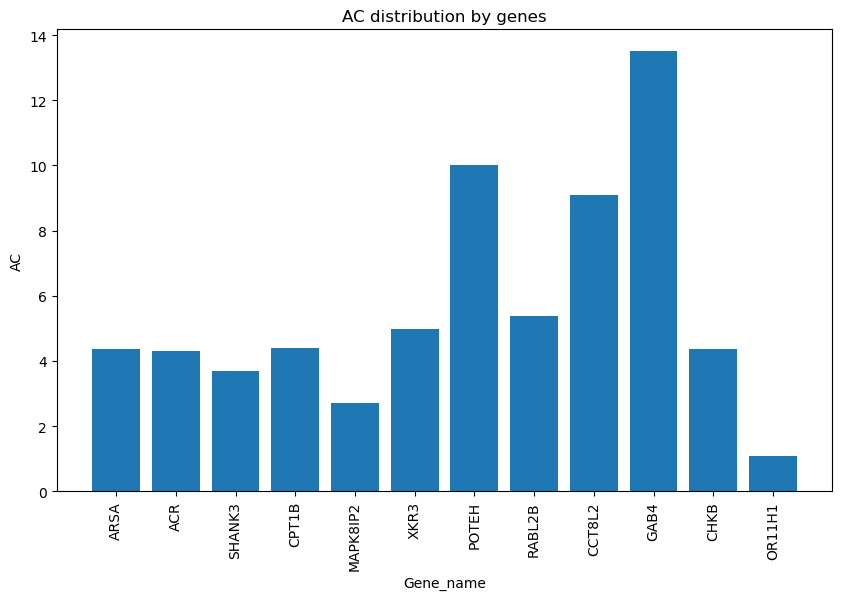

In [447]:
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.bar(new_dataframe['Gene_name'], np.log1p(new_dataframe['AC']))  # Create a bar plot
plt.xlabel('Gene_name')  # X-axis label
plt.ylabel('AC')  # Y-axis label
plt.title('AC distribution by genes')  # Set the title
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

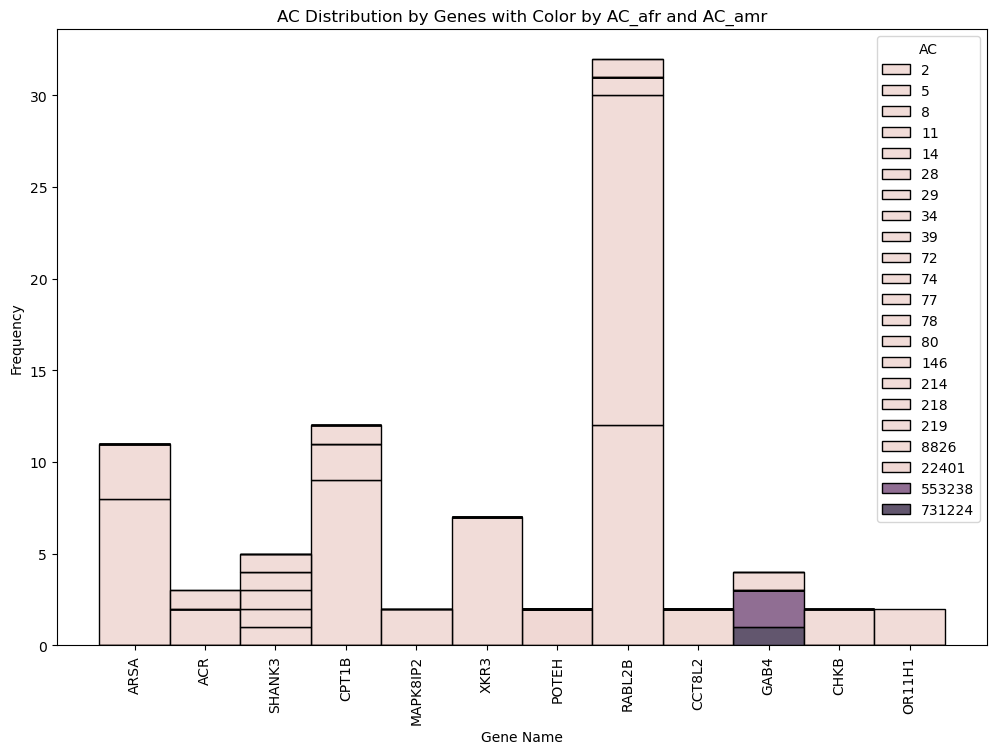

In [269]:
plt.figure(figsize=(12, 8))
sns.histplot(data=new_dataframe, x='Gene_name', hue='AC', multiple='stack')
plt.title('AC Distribution by Genes with Color by AC_afr and AC_amr')
plt.xlabel('Gene Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()